In [1]:
import os
import time 

import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from tqdm.auto import trange

plt.set_cmap('gray')

<Figure size 432x288 with 0 Axes>

In [2]:
def imsave(image: np.ndarray, path):
    norm_image = (((image - image.min()) / (image.max() - image.min())) * 255).astype(np.uint8)
    cv2.imwrite(path, norm_image)

# Part 1

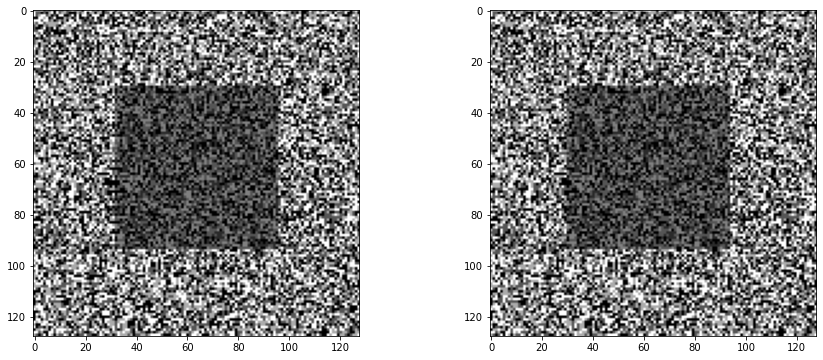

In [3]:
L = cv2.imread(os.path.join('input', 'pair0-L.png'), 0) / 255
R = cv2.imread(os.path.join('input', 'pair0-R.png'), 0) / 255

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(L)
plt.subplot(122)
plt.imshow(R)
plt.show()

## Part A

Implement the SSD match algorithm as function disparity_ssd(L, R) that returns a disparity image D(y,x) such that L(y,x) = R(y,x+D(y,x)) when matching from left (L) to right (R).

You will implement this function in numerous versions, pixel-wise, vectorized and with shared computations.

Consider what parameters you'd like your function to have

### Pixel wise

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

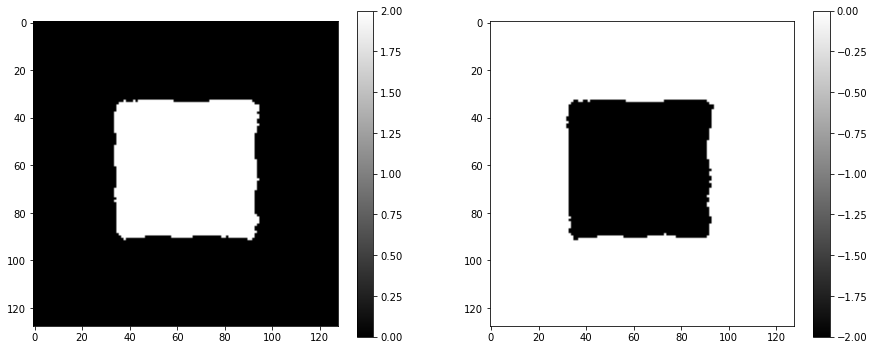

In [4]:
def disparity_ssd_pixel_wise(L: np.ndarray, R: np.ndarray, w, d_max):
    """Compute disparity map D(y, x) such that: L(y, x) = R(y, x + D(y, x))

    Params:
    L: Grayscale left image
    R: Grayscale right image, same size as L
    w: Window size
    d_max: Maximum disparity

    Returns: Disparity map, same size as L, R
    """
    assert  w % 2 == 1
    n_rows, n_cols = L.shape
    D = np.empty_like(L)
    pad_L = np.pad(L, w // 2)
    pad_R = np.pad(R, w // 2)

    L_patches = sliding_window_view(pad_L, (w, w))
    R_patches = sliding_window_view(pad_R, (w, w))
    for i in trange(n_rows):
        for j in range(n_cols):
            start = max(j - d_max, 0) if d_max else 0
            end = min(j + d_max, n_cols) if d_max else -1
            ssd_arr = np.sum(np.square(L_patches[i, j] - R_patches[i, start:end]), axis=(-2, -1))
            match = np.argmin(ssd_arr) + start
            D[i, j] = j - match
    return D


D_L = disparity_ssd_pixel_wise(L, R, w=11, d_max=10)
D_R = disparity_ssd_pixel_wise(R, L, w=11, d_max=10)

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(D_L)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R)
plt.colorbar()
plt.show()

This looks pretty much perfect.

### Vectorized

How would you like to vectorize the functions? Try out a few variations.

Consider the parameters of your function as well as memory constraints.

You can ask the team mates for hints if you'd like.

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

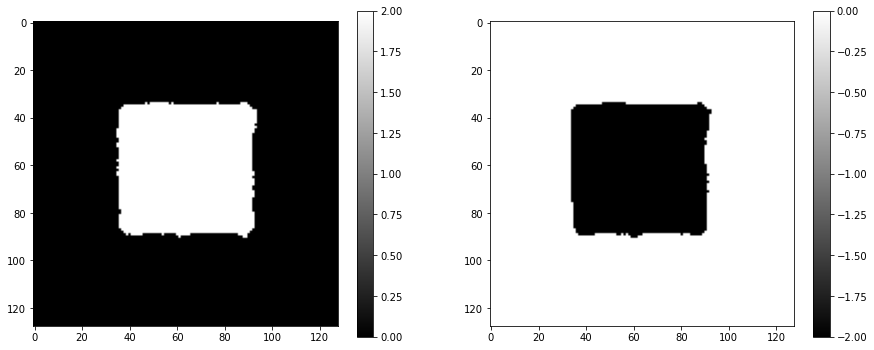

In [5]:
def disparity_ssd_row_wise(L: np.ndarray, R: np.ndarray, w, d_max=None):
    """Compute disparity map D(y, x) such that: L(y, x) = R(y, x + D(y, x))

    Params:
    L: Grayscale left image
    R: Grayscale right image, same size as L
    w: Window size

    Returns: Disparity map, same size as L, R
    """
    assert w % 2 == 1
    if d_max is not None:
        print('d_max doesnt do anything')

    n_rows, n_cols = L.shape
    D = np.empty_like(L)
    pad_L = np.pad(L, w // 2)
    pad_R = np.pad(R, w // 2)

    L_patches = sliding_window_view(pad_L, (w, w))
    R_patches = sliding_window_view(pad_R, (w, w))

    L_patches = L_patches[:, :, np.newaxis]
    R_patches = R_patches[:, np.newaxis, :]
    for i in trange(n_rows):
        ssd_mat = np.nansum(np.square(L_patches[i] - R_patches[i]), axis=(-2, -1))
        matches = np.argmin(ssd_mat, -1)
        D[i] = np.arange(n_cols) - matches
    return D


D_L = disparity_ssd_row_wise(L, R, 15)
D_R = disparity_ssd_row_wise(R, L, 15)

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(D_L)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R)
plt.colorbar()
plt.show()

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

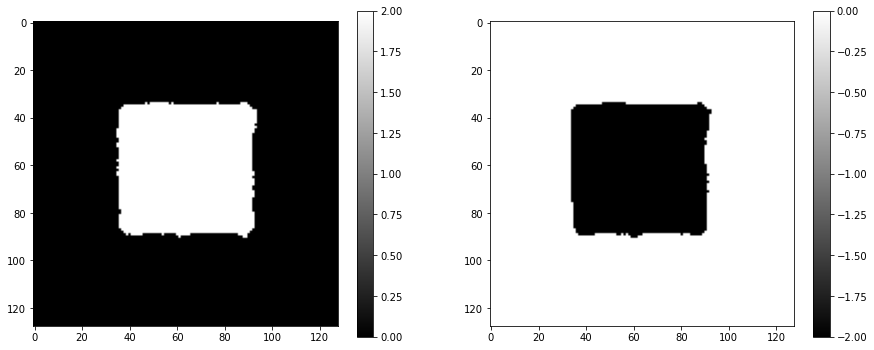

In [6]:
def disparity_ssd_col_wise(L: np.ndarray, R: np.ndarray, w, d_max):
    """Compute disparity map D(y, x) such that: L(y, x) = R(y, x + D(y, x))

    Params:
    L: Grayscale left image
    R: Grayscale right image, same size as L
    w: Window size

    Returns: Disparity map, same size as L, R
    """
    assert w % 2 == 1
    n_rows, n_cols = L.shape
    D = np.empty_like(L)
    pad_L = np.pad(L, w // 2)
    pad_R = np.pad(R, w // 2)

    L_patches = sliding_window_view(pad_L, (w, w))
    R_patches = sliding_window_view(pad_R, (w, w))
    for c in trange(n_cols):
        start = max(c - d_max, 0) if d_max else 0
        end = min(c + d_max, n_cols) if d_max else -1
        ssd_arr = np.sum(np.square(L_patches[:, [c]] - R_patches[:, start:end]), axis=(-2, -1))
        match = np.argmin(ssd_arr, axis=-1) + start
        D[:, c] = c - match
    return D


D_L = disparity_ssd_col_wise(L, R, 15, 20)
D_R = disparity_ssd_col_wise(R, L, 15, 20)

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(D_L)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R)
plt.colorbar()
plt.show()

The computations took 16.50s in total
The computations took 3.53s in total


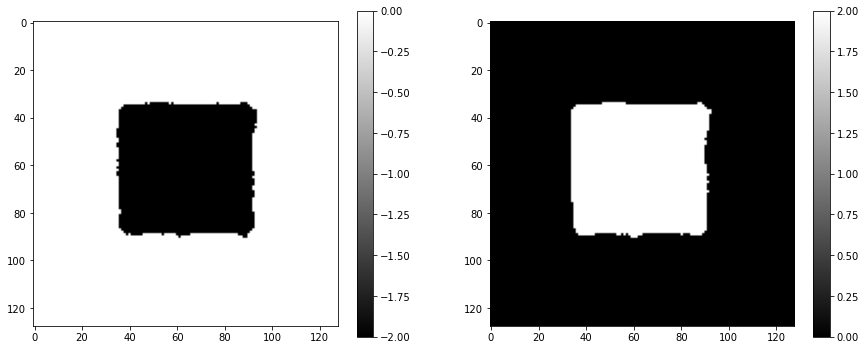

In [7]:
def disparity_ssd_matrix_wise(L: np.ndarray, R: np.ndarray, w, d_max=None):
    """Compute disparity map D(y, x) such that: L(y, x) = R(y, x + D(y, x))

    Params:
    L: Grayscale left image
    R: Grayscale right image, same size as L
    w: Window size

    Returns: Disparity map, same size as L, R
    """
    assert w % 2 == 1
    if d_max is not None:
        print('d_max doesnt do anything')
    n_rows, n_cols = L.shape
    pad_L = np.pad(L, w // 2)
    pad_R = np.pad(R, w // 2)

    L_patches = sliding_window_view(pad_L, (w, w))
    R_patches = sliding_window_view(pad_R, (w, w))

    L_patches = L_patches[:, :, np.newaxis]
    R_patches = R_patches[:, np.newaxis, :]
    
    start = time.time()
    ssd_mat = np.sum(np.square(L_patches - R_patches), axis=(-2, -1))
    matches = np.argmin(ssd_mat, -1)
    D = matches - np.arange(n_cols)
    print('The computations took {:.2f}s in total'.format(time.time() - start))
    return D


D_L = disparity_ssd_matrix_wise(L, R, 15)
D_R = disparity_ssd_matrix_wise(R, L, 15)

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(D_L)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R)
plt.colorbar()
plt.show()

### Shared Computations

This version is faster for two reasons:

1. The main one, it uses cv2.blur to compute the means, which uses fourier and is much faster. This gives about an 8x speedup.
2. In the old version each 2 pixels are subtracted at most $w^2$ times, in this version at most once. This gives about a 2x speedup.

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

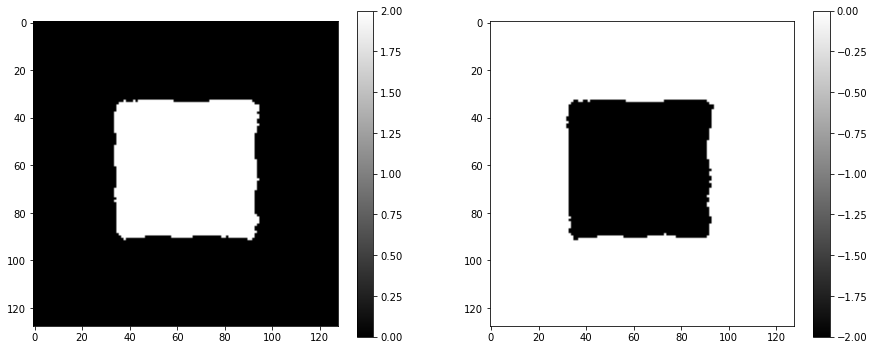

In [8]:
def shift_image(image, d):
    if d == 0:
        return image 
    shifted_image = np.roll(image, d, axis=1)
    if d > 0:
        shifted_image[:, :d] = 0
    else:
        shifted_image[:, d:] = 0
    return shifted_image
    

def disparity_ssd_shared(L: np.ndarray, R: np.ndarray, w, d_max):
    """Compute disparity map D(y, x) such that: L(y, x) = R(y, x + D(y, x))

    Params:
    L: Grayscale left image
    R: Grayscale right image, same size as L
    w: Window size

    Returns: Disparity map, same size as L, R
    """
    assert  w % 2 == 1
    ssd_matrices = np.empty((2 * d_max + 1, *L.shape))
    n_cols = L.shape[1]

    for d in trange(-d_max, d_max + 1):
        shifted_R = shift_image(R, d)
        ssd_matrices[d + d_max] = cv2.blur(np.square(L - shifted_R), (w, w))

    D = np.empty_like(L)
    for c in trange(n_cols):
        start = max(d_max - c, 0)
        end = min(n_cols - c, d_max) + d_max + 1
        rel_ssd_matrices = ssd_matrices[start:end, :, c]
        disparities = np.argmin(rel_ssd_matrices, axis=0) - (d_max - start)
        D[:, c] = disparities
    return D


D_L = disparity_ssd_shared(L, R, w=11, d_max=10)
D_R = disparity_ssd_shared(R, L, w=11, d_max=10)

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(D_L)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R)
plt.colorbar()
plt.show()

# Part 2 A

Again apply your SSD match function, and create a disparity image D(y,x) such that L(y,x) = R(y,x+D(y,x)) when matching from left to right. Also match from right to left.

Try out the different versions you implemented and compare their runtimes and results. The results should all be the same.

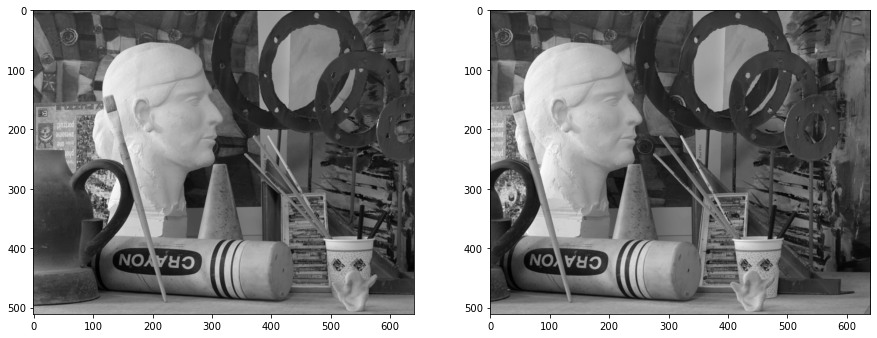

In [9]:
L = cv2.imread(os.path.join('input', 'pair1-L.png'), 0) / 255
R = cv2.imread(os.path.join('input', 'pair1-R.png'), 0) / 255

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(L)
plt.subplot(122)
plt.imshow(R)
plt.show()

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

Total runtime for function disparity_ssd_pixel_wise is 38.05s


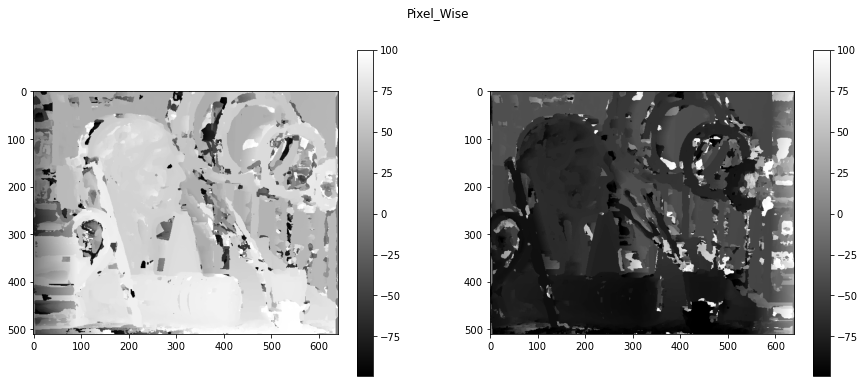

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Total runtime for function disparity_ssd_col_wise is 97.60s


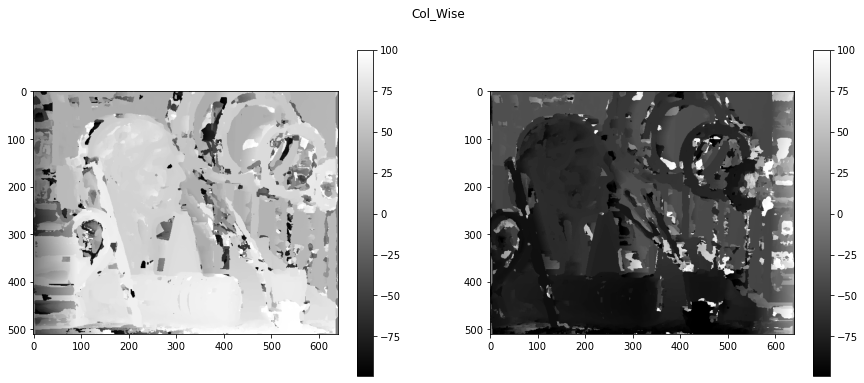

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Total runtime for function disparity_ssd_shared is 2.99s


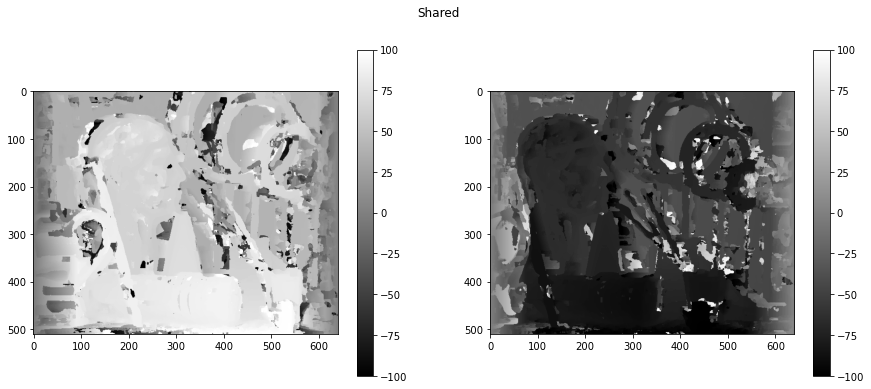

In [10]:
for disparity_func in [
    disparity_ssd_pixel_wise,
#     disparity_ssd_row_wise,  # it doesn't work with d_max - results are bad and runtime is long
    disparity_ssd_col_wise,
#     disparity_ssd_matrix_wise, # it causes a memory overload
    disparity_ssd_shared,
]:
    start = time.time()
    d_max = 100
    D_L = disparity_func(L, R, w=11, d_max=d_max)
    D_R = disparity_func(R, L, w=11, d_max=d_max)
    print('Total runtime for function {} is {:.2f}s'.format(disparity_func.__name__, time.time() - start))

    plt.figure(figsize=(15, 6))
    plt.suptitle(disparity_func.__name__.replace('disparity_ssd_', '').title())
    plt.subplot(121)
    plt.imshow(D_L)
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(D_R)
    plt.colorbar()
    plt.show()

Surprisingly, pixel wise is much faster than columns wise. 

Unsurprisingly, the shared version is the fastest and produces almost identical results, so we'll use it from now on.

# Part 2 b

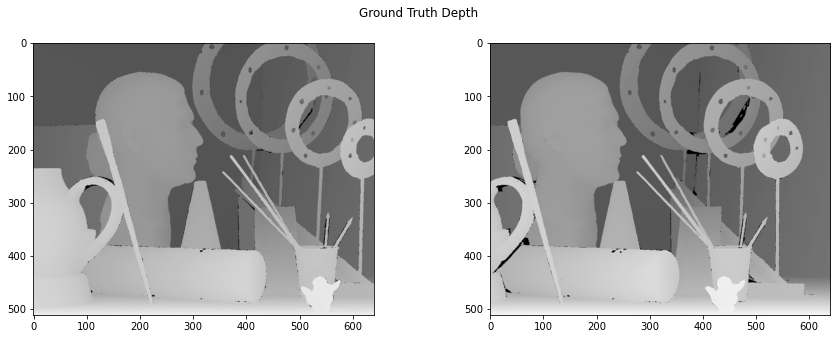

In [11]:
gt_D_L = cv2.imread(os.path.join('input', 'pair1-D_L.png'), 0) / 255
gt_D_R = cv2.imread(os.path.join('input', 'pair1-D_R.png'), 0) / 255

plt.figure(figsize=(15, 5))
plt.suptitle('Ground Truth Depth')
plt.subplot(121)
plt.imshow(gt_D_L)
plt.subplot(122)
plt.imshow(gt_D_R)
plt.show()

This is obviously much clearer than the depth our function gets, but a lot of the underlying structure is seen in both pictures.

# Part 3 a

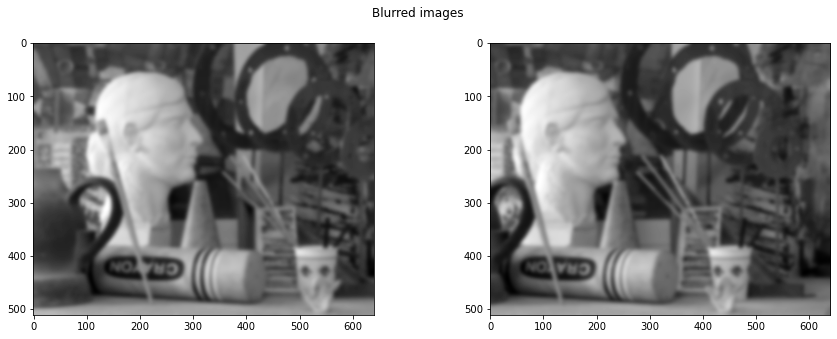

In [12]:
L_blur = cv2.GaussianBlur(L, (21, 21), 0)
R_blur = cv2.GaussianBlur(R, (21, 21), 0)

plt.figure(figsize=(15, 5))
plt.suptitle('Blurred images')
plt.subplot(121)
plt.imshow(L_blur)
plt.subplot(122)
plt.imshow(R_blur)
plt.show()

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

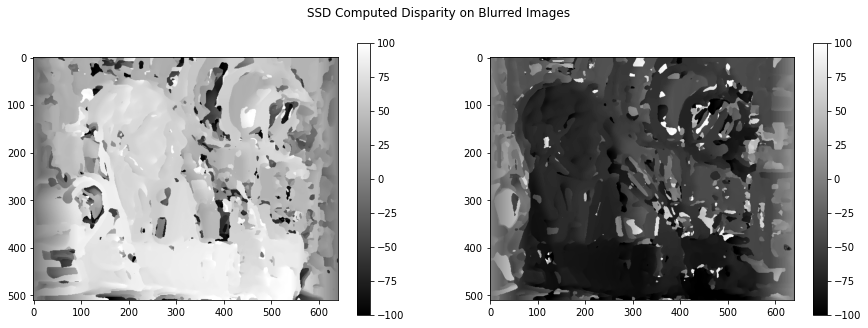

In [13]:
w = 11
d_max = 100
D_L_blur = disparity_ssd_shared(L_blur, R_blur, w, d_max)
D_R_blur = disparity_ssd_shared(R_blur, L_blur, w, d_max)

plt.figure(figsize=(15, 5))
plt.suptitle('SSD Computed Disparity on Blurred Images')
plt.subplot(121)
plt.imshow(D_L_blur)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R_blur)
plt.colorbar()
plt.show()

This doesn't look as good as it did before, the resolution is lower.

# Part 3 b

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

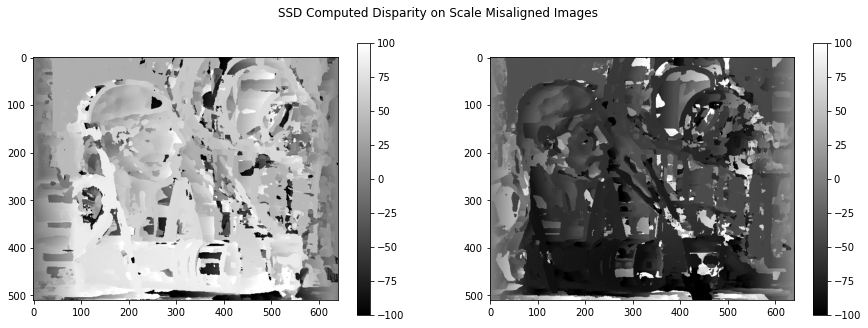

In [14]:
R_contrast = R * 1.1

D_L_cont = disparity_ssd_shared(L, R_contrast, w, d_max)
D_R_cont = disparity_ssd_shared(R_contrast, L, w, d_max)

plt.figure(figsize=(15, 5))
plt.suptitle('SSD Computed Disparity on Scale Misaligned Images')
plt.subplot(121)
plt.imshow(D_L_cont)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R_cont)
plt.colorbar()
plt.show()

imsave(D_L_blur, 'output/ps2-3-b-1.png')
imsave(D_R_blur, 'output/ps2-3-b-2.png')

This looks much worst than before, theres much more noise.

# Part 4 a

Implement a window matching stereo algorithm using some form of normalized correlation. Again, write this as a function disparity_ncorr(L, R) that returns a disparity image D(y,x) such that L(y,x) = R(y,x+D(y,x)) when matching from left (L) to right (R). 

Use OpenCV's funtion matchTemplate with flag TM_CCOEFF_NORMED. Take a look at some of the other flags they have available.

*Question*: What is the most efficient possible implementation of this new disparity function? Pixel-wise/column-wise/shared compuatation?

In [15]:
def disparity_ncorr(L, R, w, d_max):
    assert w % 2 == 1
    n_rows, n_cols = L.shape
    D = np.empty_like(L)
    pad_L = np.pad(L, w // 2).astype(np.float32)
    pad_R = np.pad(R, w // 2).astype(np.float32)

    L_windows = sliding_window_view(pad_L, (w, w))
    R_rows = sliding_window_view(pad_R, w, axis=0).transpose([0, 2, 1])

    for i in trange(n_rows):
        for j in range(n_cols):
            start = max(j - d_max, 0)
            R_row = R_rows[i, :, start:j + d_max]
            corr_matrix = cv2.matchTemplate(R_row, L_windows[i, j], cv2.TM_CCOEFF_NORMED)[0]
            matches_idx = np.argmax(corr_matrix) + start
            D[i, j] = matches_idx - j
    return D

In [16]:
w = 11
d_max = 100
D_L = disparity_ncorr(L, R, w, d_max)
D_R = disparity_ncorr(R, L, w, d_max)

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

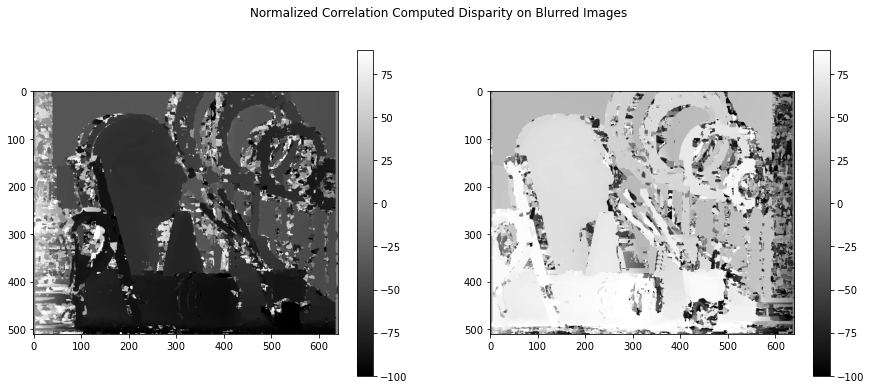

In [17]:
plt.figure(figsize=(15, 6))
plt.suptitle('Normalized Correlation Computed Disparity on Blurred Images')
plt.subplot(121)
plt.imshow(D_L)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R)
plt.colorbar()
plt.show()

imsave(D_L, 'output/ps2-4-a-1.png')
imsave(D_R, 'output/ps2-4-a-2.png')

This is slower than our own SSD, since it doesn't share any computations, but the results are much better and clearer.

# Part 4 b

### Now test it on both the noisy and contrast-boosted versions from 2-a and 2-b.

This new function should be more robust to pertubations, since it normalizes each patch by itself.

Let's try it on the blurred version:

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

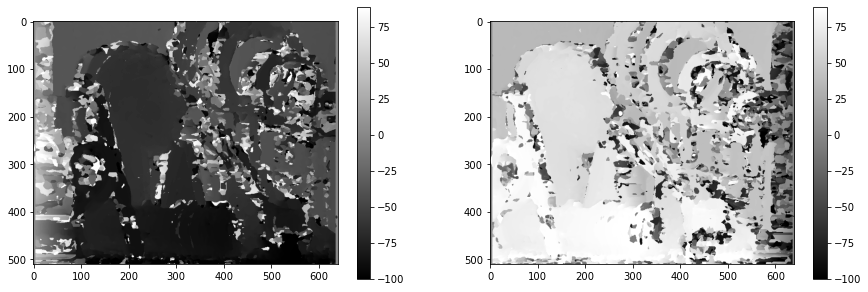

In [18]:
w = 11
d_max = 100
D_L_blur_ncorr = disparity_ncorr(L_blur, R_blur, w, d_max)
D_R_blur_ncorr = disparity_ncorr(R_blur, L_blur, w, d_max)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(D_L_blur_ncorr)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R_blur_ncorr)
plt.colorbar()
plt.show()

This looks almost identical to the version computed on the original images, it seems like there was very little effect by blurring.

Now the contrast boosted version:

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

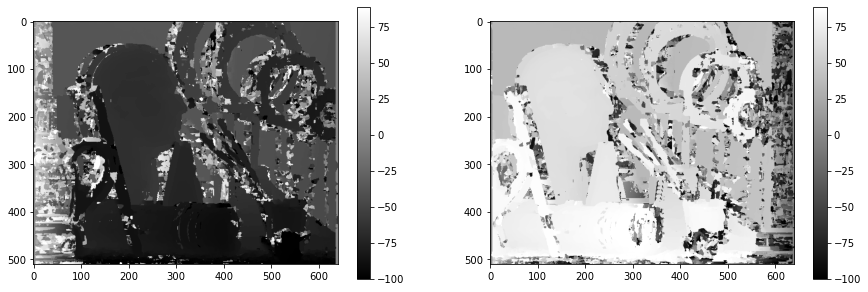

In [19]:
R_contrast = R * 1.1

D_L_cont_ncorr = disparity_ncorr(L, R_contrast, w, d_max)
D_R_cont_ncorr = disparity_ncorr(R_contrast, L, w, d_max)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(D_L_cont_ncorr)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R_cont_ncorr)
plt.colorbar()
plt.show()

This looks completely identical to the original disparities, which makes sense, the normalization should invert the contrast boost.

# Part 5 

Try your algorithms on this pair. Play with the images – smooth, sharpen, etc. Keep comparing to the ground truth (pair2-D_L.png and pair2-D_R.png).

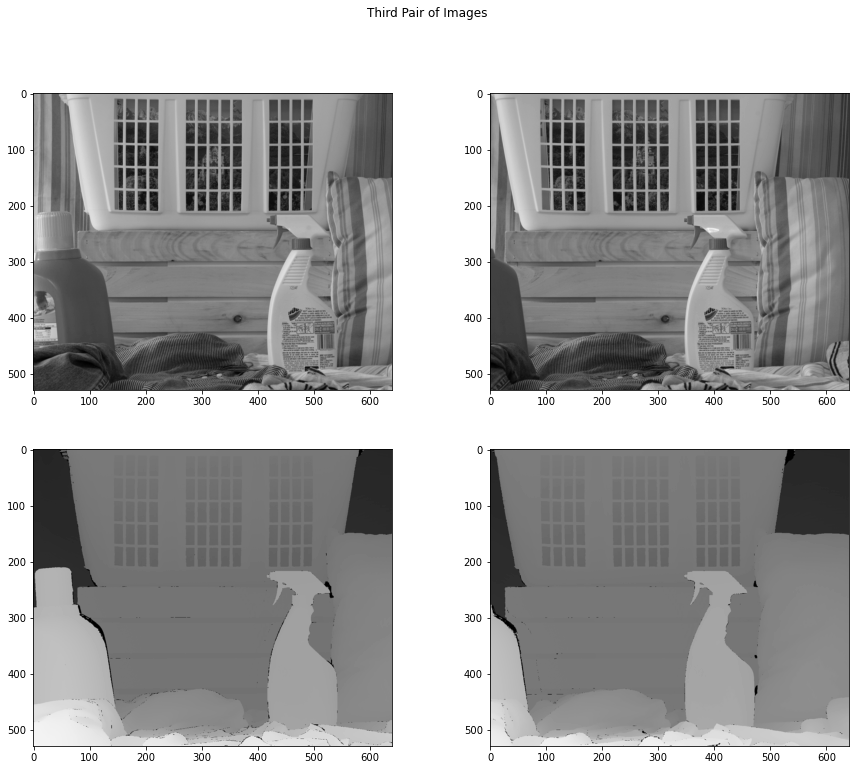

In [20]:
L = cv2.imread(os.path.join('input', 'pair2-L.png'), 0) / 255
R = cv2.imread(os.path.join('input', 'pair2-R.png'), 0) / 255
gt_D_L = cv2.imread(os.path.join('input', 'pair2-D_L.png'), 0)
gt_D_R = cv2.imread(os.path.join('input', 'pair2-D_R.png'), 0)

plt.figure(figsize=(15, 12))
plt.suptitle('Third Pair of Images')
plt.subplot(221)
plt.imshow(L)
plt.subplot(222)
plt.imshow(R)
plt.subplot(223)
plt.imshow(gt_D_L)
plt.subplot(224)
plt.imshow(gt_D_R)
plt.show()

  0%|          | 0/529 [00:00<?, ?it/s]

  0%|          | 0/529 [00:00<?, ?it/s]

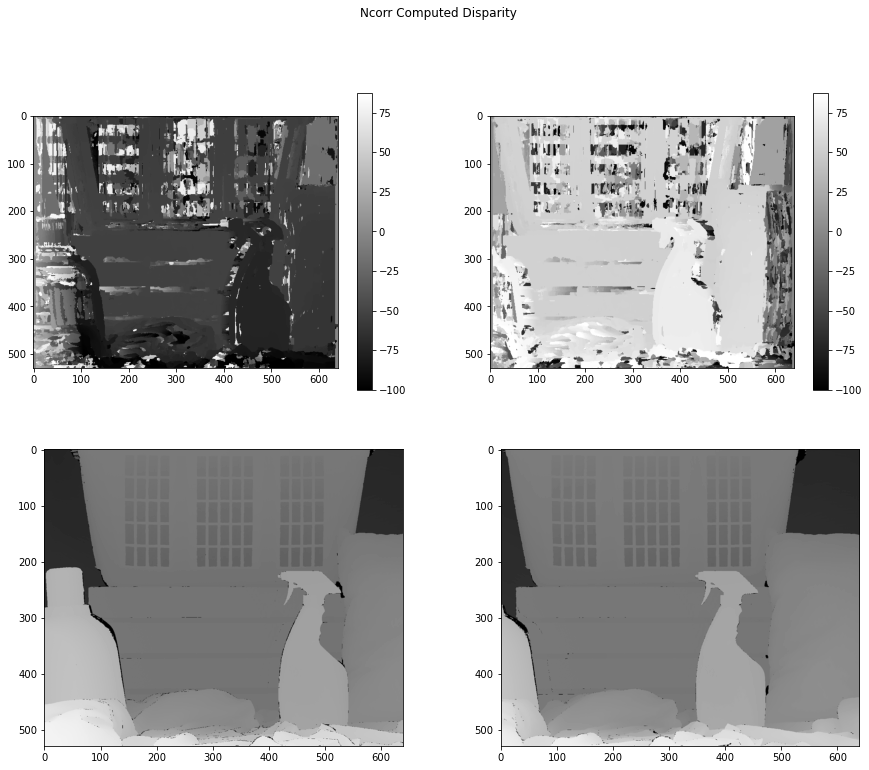

In [21]:
w = 13
d_max = 100

D_L = disparity_ncorr(L, R, w, d_max)
D_R = disparity_ncorr(R, L, w, d_max)

plt.figure(figsize=(15, 12))
plt.suptitle('Ncorr Computed Disparity')
plt.subplot(221)
plt.imshow(D_L)
plt.colorbar()
plt.subplot(222)
plt.imshow(D_R)
plt.colorbar()
plt.subplot(223)
plt.imshow(gt_D_L)
plt.subplot(224)
plt.imshow(gt_D_R)
plt.show()

This doesn't look perfect, but a lot of the underlying strucute is kept. The main trick is to set $d_{max}$ low enough to eliminate outliers and to set $w$ low enough so that it captures the structure of the cells of the laundry basket.

*Question:* Can you automate this process? If so, how?